<a href="https://colab.research.google.com/github/pashupati98/CatText/blob/master/GRU/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
url_rdf = '/content/drive/My Drive/IBM/dataset/raw_df.csv'
url_pdf = '/content/drive/My Drive/IBM/dataset/processed.csv'
url_udf = '/content/drive/My Drive/IBM/dataset/processed_user.csv'
url_olid = '/content/drive/My Drive/IBM/dataset/olid.csv'
url_hate = '/content/drive/My Drive/IBM/dataset/hate.csv'
rdf = pd.read_csv(url_rdf)
pdf = pd.read_csv(url_pdf)
udf = pd.read_csv(url_udf)
olid = pd.read_csv(url_olid)
hate = pd.read_csv(url_hate)

In [5]:
olid.head()

,Unnamed: 0,tweet,label
0,0,@USER She should ask a few native Americans wh...,1
1,1,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
2,2,Amazon is investigating Chinese employees who ...,0
3,3,"@USER Someone should'veTaken"" this piece of sh...",1
4,4,@USER @USER Obama wanted liberals &amp; illega...,0


In [0]:
from keras.layers import Dropout, Dense, GRU, Embedding
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [0]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open("/content/drive/My Drive/IBM/Glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [0]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    gru_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(gru_node)
    for i in range(0,hidden_layer):
        model.add(GRU(gru_node,return_sequences=True, recurrent_dropout=0.2))
        model.add(Dropout(dropout))
    model.add(GRU(gru_node, recurrent_dropout=0.2))
    model.add(Dropout(dropout))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [0]:
def experiment(df):
  print("Running Experiment ... ")
  X = df.tweet
  y = df.label
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=10,
                              batch_size=128,
                              verbose=1)
  print("\n Plotting results ... \n")
  plot_graphs(history, 'acc')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict_classes(X_test_Glove)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))

In [0]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [0]:
def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

### Experiment with RDF

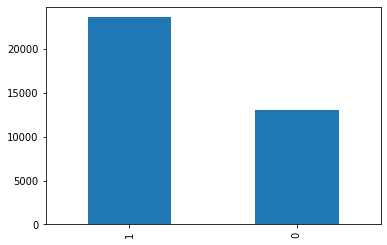

In [0]:
class_balance(rdf,'label')

In [0]:
srdf = shuffle(rdf)

Running Experiment ... 
Generating Glove ...
Found 47632 unique tokens.
(36593, 500)
Total 400000 word vectors.
Building Model ...
32
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           2381650   
_________________________________________________________________
gru_5 (GRU)                  (None, 500, 32)           7968      
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 500, 32)        

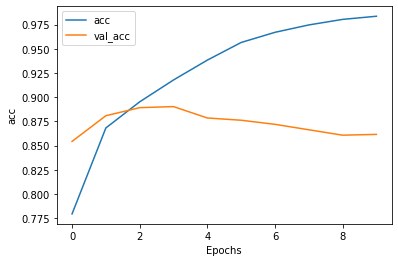

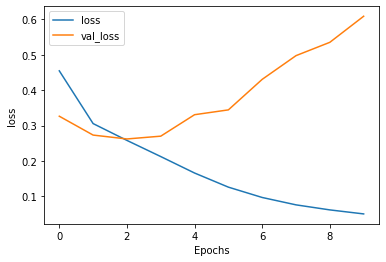


 Evaluating Model ... 



INFO:logger:  mcc = 0.6952682086388055
INFO:logger:  tp = 4273
INFO:logger:  tn = 2033
INFO:logger:  fp = 574
INFO:logger:  fn = 439
INFO:logger:  pricision = 0.8815762327212708
INFO:logger:  recall = 0.9068336162988115
INFO:logger:  F1 = 0.8940265718171356
INFO:logger:  accuracy = 0.8615931138133625


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2607
           1       0.88      0.91      0.89      4712

    accuracy                           0.86      7319
   macro avg       0.85      0.84      0.85      7319
weighted avg       0.86      0.86      0.86      7319





In [16]:
experiment(srdf)

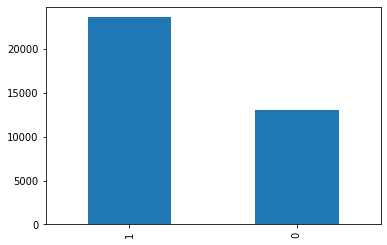

In [0]:
class_balance(pdf,'label')

In [0]:
spdf = shuffle(pdf)

Running Experiment ... 
Generating Glove ...
Found 45504 unique tokens.
(36593, 500)
Total 400000 word vectors.
Building Model ...



32



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           2275250   
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 32)           7968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 29274 samples, validate on 7319 samples
Epoch 1/10
29274/29274 [==============================] - 694s 24ms/step - loss: 0.4556 - acc: 0.7803 - val_loss: 0.3299 - val_acc: 0.8524
Epoch 2/10
29274/29274 [==============================] - 699s 24ms/step - loss: 0.3106 - acc: 0.8663 - val_loss: 0.2848 - val_acc: 0.8773
Epoch 3/10
29274/29274 [==============================] - 702s 24ms/step - loss: 0.2632 - acc: 0.8936 - val_loss: 0.2695 - val_acc: 0.8844
Epoch 4/10
29274/29274 [==============================] - 706s 24ms/step - loss: 0.2235 - acc: 0.9118 - val_loss: 0.2801 - val_acc: 0.8908
Epoch 5/10
29274/29274 [==============================] - 704s 24ms/step - loss: 0.1804 - acc: 0.9320 - val_loss: 0.2879 - val_acc: 0.8892
Epoch 6/10
29274/29274 [==============================] - 692s 24ms/step - loss: 0.1424 - acc: 0.9492 - val_loss: 0.3399 - val_acc: 0.8807
Epoch 7/10
29274/29274 [==============================] - 693s 24ms/step - loss: 0.1133 - acc: 0.9604 - val_loss: 0.3

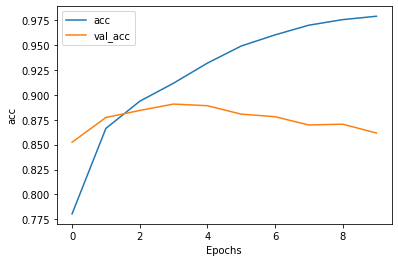

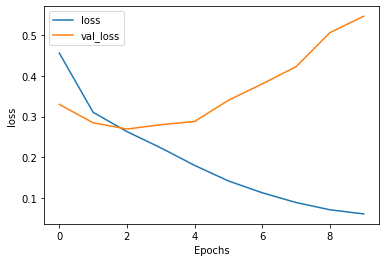


 Evaluating Model ... 



INFO:logger:  mcc = 0.6958718221770351
INFO:logger:  tp = 4271
INFO:logger:  tn = 2036
INFO:logger:  fp = 581
INFO:logger:  fn = 431
INFO:logger:  pricision = 0.8802555647155812
INFO:logger:  recall = 0.9083368779242875
INFO:logger:  F1 = 0.8940757797781034
INFO:logger:  accuracy = 0.8617297445006148


              precision    recall  f1-score   support

           0       0.83      0.78      0.80      2617
           1       0.88      0.91      0.89      4702

    accuracy                           0.86      7319
   macro avg       0.85      0.84      0.85      7319
weighted avg       0.86      0.86      0.86      7319





In [0]:
experiment(spdf)

In [0]:
# OLID

In [0]:
solid = shuffle(olid)

Running Experiment ... 
Generating Glove ...
Found 21243 unique tokens.
(13240, 500)
Total 400000 word vectors.
Building Model ...



32



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           1062200   
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 32)           7968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10592 samples, validate on 2648 samples
Epoch 1/10
10592/10592 [==============================] - 250s 24ms/step - loss: 0.6319 - acc: 0.6593 - val_loss: 0.5938 - val_acc: 0.6903
Epoch 2/10
10592/10592 [==============================] - 239s 23ms/step - loss: 0.5796 - acc: 0.7042 - val_loss: 0.5408 - val_acc: 0.7266
Epoch 3/10
10592/10592 [==============================] - 236s 22ms/step - loss: 0.5281 - acc: 0.7474 - val_loss: 0.5086 - val_acc: 0.7500
Epoch 4/10
10592/10592 [==============================] - 238s 22ms/step - loss: 0.4814 - acc: 0.7804 - val_loss: 0.5246 - val_acc: 0.7602
Epoch 5/10
10592/10592 [==============================] - 237s 22ms/step - loss: 0.4400 - acc: 0.8061 - val_loss: 0.4923 - val_acc: 0.7632
Epoch 6/10
10592/10592 [==============================] - 236s 22ms/step - loss: 0.4001 - acc: 0.8316 - val_loss: 0.5233 - val_acc: 0.7598
Epoch 7/10
10592/10592 [==============================] - 236s 22ms/step - loss: 0.3535 - acc: 0.8583 - val_loss: 0.5

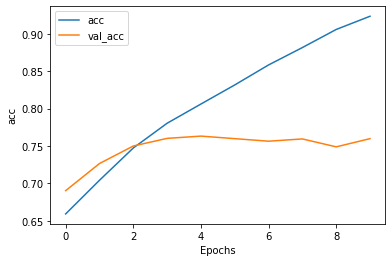

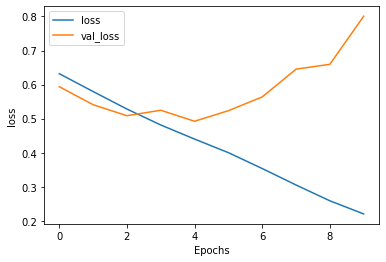


 Evaluating Model ... 



INFO:logger:  mcc = 0.44990903499878504
INFO:logger:  tp = 529
INFO:logger:  tn = 1483
INFO:logger:  fp = 275
INFO:logger:  fn = 361
INFO:logger:  pricision = 0.6579601990049752
INFO:logger:  recall = 0.5943820224719101
INFO:logger:  F1 = 0.6245572609208973
INFO:logger:  accuracy = 0.7598187311178247


              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1758
           1       0.66      0.59      0.62       890

    accuracy                           0.76      2648
   macro avg       0.73      0.72      0.72      2648
weighted avg       0.76      0.76      0.76      2648





In [16]:
experiment(solid)

In [0]:
shate = shuffle(hate)

Running Experiment ... 
Generating Glove ...
Found 35078 unique tokens.
(23353, 500)
Total 400000 word vectors.
Building Model ...



32



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           1753950   
_________________________________________________________________
gru_1 (GRU)                  (None, 500, 32)           7968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 500, 32)           6240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)          

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 18682 samples, validate on 4671 samples
Epoch 1/10
18682/18682 [==============================] - 520s 28ms/step - loss: 0.3788 - acc: 0.8463 - val_loss: 0.2273 - val_acc: 0.9049
Epoch 2/10
18682/18682 [==============================] - 524s 28ms/step - loss: 0.2011 - acc: 0.9217 - val_loss: 0.1422 - val_acc: 0.9396
Epoch 3/10
18682/18682 [==============================] - 518s 28ms/step - loss: 0.1402 - acc: 0.9486 - val_loss: 0.1313 - val_acc: 0.9518
Epoch 4/10
18682/18682 [==============================] - 513s 27ms/step - loss: 0.1113 - acc: 0.9622 - val_loss: 0.1341 - val_acc: 0.9544
Epoch 5/10
18682/18682 [==============================] - 511s 27ms/step - loss: 0.0877 - acc: 0.9727 - val_loss: 0.1371 - val_acc: 0.9546
Epoch 6/10
18682/18682 [==============================] - 511s 27ms/step - loss: 0.0667 - acc: 0.9792 - val_loss: 0.1509 - val_acc: 0.9484
Epoch 7/10
18682/18682 [==============================] - 512s 27ms/step - loss: 0.0475 - acc: 0.9864 - val_loss: 0.1

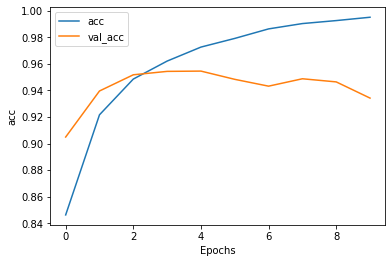

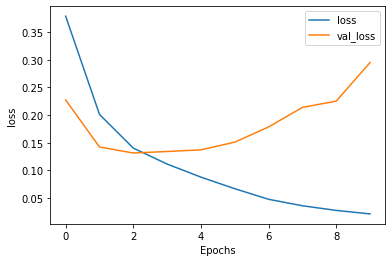


 Evaluating Model ... 



INFO:logger:  mcc = 0.7630997602022059
INFO:logger:  tp = 3769
INFO:logger:  tn = 595
INFO:logger:  fp = 237
INFO:logger:  fn = 70
INFO:logger:  pricision = 0.9408387418871692
INFO:logger:  recall = 0.9817660849179474
INFO:logger:  F1 = 0.9608667941363925
INFO:logger:  accuracy = 0.934275315778206


              precision    recall  f1-score   support

           0       0.89      0.72      0.79       832
           1       0.94      0.98      0.96      3839

    accuracy                           0.93      4671
   macro avg       0.92      0.85      0.88      4671
weighted avg       0.93      0.93      0.93      4671





In [14]:
experiment(shate)